In [3]:
class SuppressOutput:
    def __enter__(self):
        self.stdout = sys.stdout
        self.stderr = sys.stderr
        self.devnull = open(os.devnull, 'w')
        sys.stdout = self.devnull
        sys.stderr = self.devnull

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self.stdout
        sys.stderr = self.stderr


In [4]:
def filter_data(ticker_list, start, end):

    data_list = []
    volume_list = []
    tickers = []

    for ticker in ticker_list:
        with SuppressOutput():
            data = yf.download(ticker, start=start, end=end)
        volume_list.append(np.mean(data['Volume']))
        tickers.append(ticker)
        data_list.append(data)

    # zipped_lists = zip(volume_list, data_list, ticker_list)

    # # Sort the zipped pairs based on list1
    # sorted_pairs = sorted(zipped_lists, key=lambda x: x[0])

    # # Extract the sorted elements into list1 and the corresponding elements into list2
    # volumes, data_list, tickers,  = zip(*sorted_pairs)

    # # Convert the result back to lists (if needed)
    # data_list = list(data_list)[50:]
    # ticker_list = list(tickers)[50:]

    return dict(zip(ticker_list, data_list))
        

    

In [34]:
def create_data(ticker, ticker_name, l_wind, s_wind, wind):

    df = pd.DataFrame(ticker)
    date = df.index.tolist()
    df['Date'] = pd.to_datetime(date)

    df['Index'] = list(range(0, len(df['Date'])))

    large_window = l_wind
    small_window = s_wind
    window = wind

    # Calculate the moving average
    df['LMA'] = df['Open'].ewm(span=large_window, adjust=False).mean()
    df['SMA'] = df['Open'].ewm(span=small_window, adjust=False).mean()
    df['MACD'] = (df['SMA'] - df['LMA']) / df['LMA']
    df['MA'] = df['MACD'].ewm(span=9, adjust=False).mean()

    return df







In [6]:
def create_train_set(ticker_list, start_date, end_date, large_window, short_window, window):
    ticker_dict = filter_data(ticker_list, start_date, end_date)

    for ticker in ticker_dict.keys():
        data = ticker_dict.get(ticker)
        ticker_dict[ticker] = create_data(data, ticker, large_window, short_window, window)

    return ticker_dict


def train_model(ticker_dict, large_window, short_window, window):

    train_set = []

    for ticker in ticker_dict.keys():
        train_set = train_set + get_crossover_data(ticker_dict[ticker], window)

    lma = [lma for _, lma, _ in train_set]
    sma = [sma for _, _, sma in train_set]
    gain = [gain for gain, _, _ in train_set]

    fig = plt.figure(figsize = (20, 8))
    plt.scatter(lma, sma, c=gain, cmap='bwr', marker='o')

    # Add color bar
    cbar = plt.colorbar()
    cbar.set_label('Binary Value')

    plt.title("Scatter plot of winning (red) and losing (blue) trades based on rate of change in moving averages")
    plt.xlabel("Long-term Moving Average")
    plt.ylabel("Short-term Moving Average")

    # Show the plot
    plt.show()

    target = [target for target, _, _ in train_set]
    features = [(x,y) for _,x,y in train_set]

    print("Valid crossovers:", len(target))
    print("Successful crossovers:", target.count(1))

    model = RandomForestClassifier(n_estimators = 50, max_depth = 4)
    # model = LogisticRegression()
    model.fit(features, target)

    # Make predictions on the test set
    y_pred = model.predict(features)

    preds = list(y_pred)

    correct_signals = 0

    trades = 0

    for i in range(0, len(preds)):
        confidence = model.predict_proba(np.array(features[i]).reshape(1, -1))[0, 1]
        if preds[i] == 1 and confidence > .7:
            trades += 1
            if preds[i] == target[i]:
                correct_signals += 1

    print("Amount of trades", trades)
    print("Amount of successful trades", correct_signals)
    # Calculate accuracy
    accuracy = accuracy_score(target, y_pred)
    print("Accuracy:", accuracy)

    return model



In [7]:
def create_test_set(ticker_list, start_date, end_date, large_window, short_window, window):
    ticker_dict = filter_data(ticker_list, start_date, end_date)

    for ticker in ticker_dict.keys():
        data = ticker_dict.get(ticker)
        ticker_dict[ticker] = create_data(data, ticker, large_window, short_window, window)

    return ticker_dict

def test_model(ticker_dict, large_window, short_window, window, model):

    train_set = []

    for ticker in ticker_dict.keys():
        train_set = train_set + get_crossover_data(ticker_dict[ticker], window)

    target = [target for target, _, _ in train_set]
    features = [(x,y) for _,x,y in train_set]

    print("Valid crossovers:", len(target))
    print("Successful crossovers:", target.count(1))

    # Make predictions on the test set
    y_pred = model.predict(features)

    preds = list(y_pred)

    print("Predicted successful crossovers:", preds.count(1))

    correct_signals = 0

    trades = 0

    for i in range(0, len(preds)):
        confidence = model.predict_proba(np.array(features[i]).reshape(1, -1))[0, 1]
        if preds[i] == 1 and confidence > .8:
            trades += 1
            if preds[i] == target[i]:
                correct_signals += 1

    print("Amount of trades", trades)
    print("Amount of successful trades", correct_signals)
    # Calculate accuracy
    accuracy = accuracy_score(target, y_pred)
    print("Accuracy:", accuracy)

    return (correct_signals / trades, target.count(1) / len(target))



In [28]:
window = 36
large_window = 104
small_window = 48


In [291]:

init_start = '2013-09-06'
init_end = '2023-09-08'

start_date = '2020-09-01'
end_date = '2023-09-08'

recent_start = '2022-08-01'
recent_end = '2023-09-08'

long_start = '2018-08-31'
long_end = '2023-09-08'

train_start = '2010-08-31'
train_end = '2018-09-08'

first_start = "2020-09-08"
first_end = "2021-09-08"

second_start = "2021-09-08"
second_end = "2022-09-08"

third_start = "2022-09-08"
third_end = "2023-09-08"



common_ticks = [
    "TSLA", "NIO", "AMD", "WBD", "NU", "TLRY", "NVDA", "AAPL", "PLTR", "INTC",
    "AMZN", "BAC", "F", "VALE", "WBA", "PARA", "XPEV", "DELL", "DNA", "DIS",
    "NUVA", "KVUE", "RIVN", "BEKE", "MARA", "GRAB", "GOOGL", "BKI", "LCID", "T",
    "HPE", "RIG", "AFRM", "CMCSA", "SWN", "SNAP", "OPEN", "SOFI", "PFE", "BABA",
    "HZNP", "CCL", "GOOG", "LYFT", "S", "MSFT", "XOM", "AAL", "VZ", "UBER", "KMI",
    "CSCO", "GSAT", "SHOP", "USB", "PDD", "META", "WFC", "C", "BBD", "CSX", "NOK",
    "GOLD", "JD", "LU", "PYPL", "IQ", "KEY", "KO", "PLUG", "FCX", "MU", "DG", "CVNA",
    "PCG", "RYCEY", "SIRI", "TAL", "BCS", "CHWY", "MRO", "IOT", "NTNX", "HPQ", "KGC",
    "XP", "HBAN", "YMM", "SCHW", "DVN", "RBLX", "DKNG", "HOOD", "LYG", "OXY", "ET",
    "GM", "M", "HAL", "JNJ", "OLN", "BKR", "NEE", "CVE", "ABCM", "DISH", "TFC",
    "JPM", "AGNC", "IONQ", "KHC", "RF", "MRVL", "MDLZ", "FOXA", "STLA", "ROKU",
    "TSM", "CVX", "NKE", "CVS", "SBUX", "CRM", "GPS", "INFY", "QCOM", "LULU", "FITB",
    "BMY", "UL", "PDD", "SPGI", "AMAT", "RY", "HON", "NOW", "GE", "RTX", "QCOM", "IDEXY",
    "FTI", "LUV", "VFS", "ROKU", "DISH", "USB", "SLB", "BUR", "GOLD", "RIG", "BKR", "DAL",
    "KHC", "CLF", "AGNC", "SNOW", "RUN", "GGB", "AEO", "CIG", "ENB", "RF", "NEE", "PTEN", "CVX"
    "VST", "VTRS", "BTE", "CARR", "BRFS", "CLVT", "CVE", "JPM", "PR", "KGC",
    "JNJ", "NYCB", "MDLZ", "MO", "MRK", "XPEV", "JCI", "HPE", "GILD", "TEVA",
    "D", "NEM", "EQT", "NKE", "IQ", "WU", "OXY", "BCS", "FCX", "ROL", "FHN", "HST", "U", "BTG", "CNHI", "MS",
    "WMB", "FITB", "AES", "RTX", "KIM", "CVNA", "HPQ", "X", "WRK", "FNMA", "TSM", "FTNT", "AMCR", "INFY"
    "BA", "BROS", "COIN", "CTRA", "FSR", "DELL", "DIDIY", "STLA", "CVS", "BK", "JD", "COTY",
    "KDP", "SBSW", "TME", "TOST", "PSNY", "ATVI", "NWL", "CHWY", "SE", "BEKE", "PPL", "NOV", "VFC", "ZI", "VLO"
    "SBRA", "DVN", "CNQ", "BB"
]

common_ticks = list(set(common_ticks))

common_ticks = ["TSLA", "META", "AMZN", "GOOG", "GOOGL", "AAPL", "MSFT",
                 "NFLX", "TSMC", "ADBE", "ORCL", "IBM", "CRM", "INTC", "CSCO", "AMD", "SAP",
                 "QCOM", "AVGO", 'CVX', "HD", "LLY", "PG", "WMT", "LVMUY", "JPM", "XOM", "JNJ", "UNH", "BRK-A", "BRK-B",
                "GM", "MA", "NESN.SW", "MRK", "ABBV", "KO", "PEP", "COST", "SHEL", "MCD", "DIS", "NKE",
                "CAT", "LOW", "UNP", "GE"
                ]

common_init = create_train_set(common_ticks, init_start, init_end, large_window, small_window, window)
common_mid = create_train_set(common_ticks, start_date, end_date, large_window, small_window, window)
common_short = create_train_set(common_ticks, recent_start, recent_end, large_window, small_window, window)
common_long = create_train_set(common_ticks, train_start, train_end, large_window, small_window, window)
common_decade = create_train_set(common_ticks, long_start, long_end, large_window, small_window, window)

first = create_train_set(common_ticks, first_start, first_end, large_window, small_window, window)
second = create_train_set(common_ticks, second_start, second_end, large_window, small_window, window)
third = create_train_set(common_ticks, third_start, third_end, large_window, small_window, window)

In [292]:


def get_crossover_data(dataset, window):
    train_data = []
    dates = []
    macd = []
    ma = []
    price = []
    trade_dates = []
    trade_info = []
    buys = []
    for i in range(20, len(dataset) - 25):
        dates.append(dataset['Date'][i])
        macd.append(dataset['MACD'][i])
        ma.append(dataset['MA'][i])
        price.append(dataset['High'][i])
        buys.append(dataset['Open'][i])

    diff = [macd[i] - ma[i] for i in range(len(macd))]


    # for p in range(10, len(diff) - 30):
    #     if diff[p - 5] < 0 and diff[p-4] > 0:
    #         lma_change = np.mean([dataset['MACD'][n] for n in range(i - 10, i) ]) * 10
    #         sma_change = (dataset['MA'][i] - dataset['MA'][i - 10]) / dataset['MA'][i - 10] / 10
    #         ma_change = (dataset['MA'][i] - dataset['MA'][i - 10]) / dataset['MA'][i - 10] / 10
    #         trade_dates.append(dates[p + 1])
    #         trade_info.append(lma_change)

    #         if(lma_change):
    #             future = price[p+2:p+40]
    #             gain = 1 if any(value > buys[p + 1] * 1.1 for value in future) else 0
    #             # gain = 1 if (dataset['Open'][i + ] > dataset['Open'][i + 1]) else 0
    #             train_data.append((gain, lma_change, sma_change))


        # if (dataset['MACD'][i - 11] - dataset['MA'][i - 11]) <= 0 and (dataset['MACD'][i - 10] - dataset['MA'][i - 10]) > 0:
        #     # lma_change = (dataset['MACD'][i] - dataset['MACD'][i - 10]) / dataset['MACD'][i - 10] / 10
        #     lma_change = np.mean([dataset['MACD'][n] for n in range(i - 10, i) ]) * 10
        #     sma_change = (dataset['MA'][i] - dataset['MA'][i - 10]) / dataset['MA'][i - 10] / 10
        #     ma_change = (dataset['MA'][i] - dataset['MA'][i - 10]) / dataset['MA'][i - 10] / 10
        #     trade_dates.append(dataset['Date'][i - 11])
        #     trade_info.append(lma_change)

        #     if(lma_change < -.2):
        #         future = list(dataset['High'][i+2:i+60])
        #         gain = 1 if any(value > dataset['Open'][i + 1] * 1.1 for value in future) else 0
        #         # gain = 1 if (dataset['Open'][i + ] > dataset['Open'][i + 1]) else 0
        #         train_data.append((gain, lma_change, sma_change))

    # plt.figure(figsize = (20, 4))
    # plt.plot(dates, price)
    # plt.show()
    # plt.figure(figsize = (20, 4))
    cross_dates = []
    crosses = []
    loss = []
    win = []
    for m in range(10, len(diff) - 50):
        if diff[m-5] < 0 and diff[m - 4] > 0:
            cross_dates.append(dates[m])
            crosses.append(0)
            cross_dates.append(dates[m + 1])
            crosses.append(0)
            future = price[m+2:m+50]
            gain = 1 if(any(value > buys[m + 1] * 1.1 for value in future) or price[m+50] > buys[m + 1]) else 0
            # if gain == 1:
            #     for i in range(m+2,m+50):
            #         if price[i] > buys[m + 1] * 1.15:
            #             win.append(buys[i + 1] / buys[m+1])
            #             break
            # if gain == 0:
            #     loss.append(price[m+50] / buys[m + 1])
            cross_dates.append(dates[m + 50])
            crosses.append(gain)
            area = 4 * (diff[m-4] + diff[m]) / 2
            if diff[m] > .003:
                if gain == 0:
                    loss.append(price[m+50] / buys[m + 1])
                if gain == 1:
                    curr_win = price[m+50] / buys[m + 1]
                    for i in range(m+2,m+50):
                        if price[i] > buys[m + 1] * 1.1:
                            curr_win = 1.1
                            break

                    win.append(curr_win)

                train_data.append((gain, diff[m], area))
            
    print(np.mean(loss))
    print(len(loss))
    print(np.mean(win))
    print(len(win))
    # plt.plot(dates, [0] * len(dates))
    # plt.plot(dates, diff)
    # plt.scatter(cross_dates, crosses)
    # plt.show()
    # plt.figure(figsize = (20, 4))
    # plt.scatter(trade_dates, trade_info)
    # plt.show()

    return train_data

0.7290833783986375
3
1.0939435264327824
14
0.8528285730589352
3
1.0999999999999999
7
0.8903888143862451
2
1.0858212952786606
7
0.9211215530261357
1
1.10388213100315
2
0.9270381125509692
2
1.1077642407482697
1


c:\Users\sayuj\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\sayuj\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan
0
1.0796007116297517
7
nan
0
1.1008848877356623
3
0.8931814179505547
4
1.0924031544701522
8
nan
0
nan
0
0.9373641794659203
2
1.0837695416223214
6
nan
0
1.0533571029531021
4
nan
0
1.080267119837797
3
0.9511850862394882
4
1.076276740628947
8
0.9165950087310406
4
1.1
4
0.987747742249085
1
1.1
4
0.930402516936274
5
1.094581519548277
16
nan
0
1.072215266642736
6
0.9197030065018865
2
1.1
4
0.939326417354559
2
1.0912011733152611
5
nan
0
1.1
2
nan
0
nan
0
0.9903544500213026
1
1.0686768267507163
1
0.9718449153323758
1
nan
0
0.96656176199038
1
1.0826829559868036
3
0.934370406750782
2
1.0874755874833355
3
0.965081318931383
2
1.1
2
0.999200268127088
1
1.1
4
0.9184814860066197
1
1.0127300017658485
1
0.9562795250222675
2
1.0962677765394078
4
0.9859192952543336
1
1.0546081478012856
1
0.9868561577773243
1
1.0526114414160188
1
0.9626229861269153
3
1.0911625334201447
5
0.9732800043308334
2
1.1
1
nan
0
nan
0
0.9484637194369197
2
1.1
1
0.9384177891501894
1
1.1
4
0.908256880733945
1
nan
0
0.95954426430

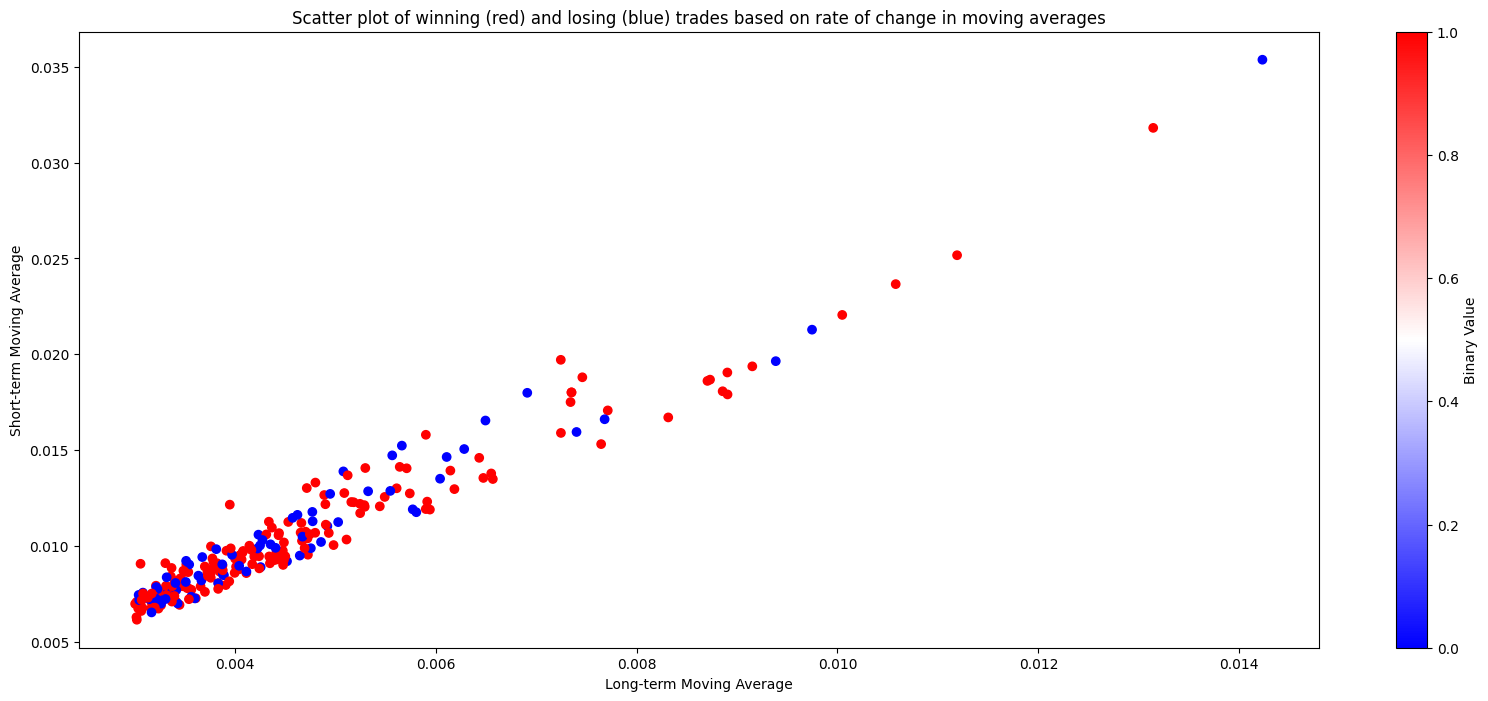

Valid crossovers: 241
Successful crossovers: 170
Amount of trades 136
Amount of successful trades 128
Accuracy: 0.7095435684647303


In [293]:

model = train_model(common_init, large_window, small_window, window)

In [286]:
test_model(common_init, large_window, small_window, window, model)

c:\Users\sayuj\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\sayuj\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan
0
1.1
2
nan
0
nan
0
0.9903544500213026
1
1.0686768267507163
1
0.9718449153323758
1
nan
0
0.96656176199038
1
1.0826829559868036
3
0.934370406750782
2
1.0874755874833355
3
0.965081318931383
2
1.1
2
0.999200268127088
1
1.1
4
0.9184814860066197
1
1.0127300017658485
1
0.9562795250222675
2
1.0962677765394078
4
0.9859192952543336
1
1.0546081478012856
1
0.9868561577773243
1
1.0526114414160188
1
Valid crossovers: 35
Successful crossovers: 22
Predicted successful crossovers: 25
Amount of trades 8
Amount of successful trades 8
Accuracy: 0.9142857142857143


(1.0, 0.6285714285714286)

In [297]:

def get_signal_data(ticker_dict, window, model):
    trade_data = []
    for ticker in ticker_dict.keys():
        dataset = ticker_dict[ticker]
        for i in range(20, len(dataset)):
            if dataset['SMA'][i - 6] <= dataset['LMA'][i - 6] and dataset['SMA'][i - 5] > dataset['LMA'][i - 5]:
                lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 10]) / dataset['LMA'][i - 10] / 10
                sma_change = (dataset['SMA'][i] - dataset['SMA'][i - 10]) / dataset['SMA'][i - 10] / 10
                ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]

                if(model.predict_proba(np.array([lma_change, sma_change]).reshape(1, -1))[0, 1] > .75):
                    date = dataset['Date'][i]
                    sell = 0
                    # sell = dataset['Open'][i + 1] * 1.1 if any(value > dataset['Open'][i + 1] * 1.1 for value in future) else dataset['Close'][i + 80]
                    trade_data.append((date, ticker))
    return trade_data


def get_new_signal_data(ticker_dict):
    trade_data = []
    for ticker in ticker_dict.keys():
        dataset = ticker_dict[ticker]
        dates = []
        macd = []
        ma = []
        price = []
        trade_dates = []
        trade_info = []
        buys = []
        for i in range(20, len(dataset) - 25):
            dates.append(dataset['Date'][i])
            macd.append(dataset['MACD'][i])
            ma.append(dataset['MA'][i])
            price.append(dataset['High'][i])
            buys.append(dataset['Open'][i])

        diff = [macd[i] - ma[i] for i in range(len(macd))]
        for m in range(10, len(diff) - 50):
            if diff[m-5] < 0 and diff[m - 4] > 0:
                if diff[m] > .003:
                    trade_data.append((dates[m], ticker))

    print(len(trade_data))

    return trade_data

def create_trade_signals(ticker_dict, window, initial_capital, trade_amount, model):
    capital = initial_capital
    trade_data = get_new_signal_data(ticker_dict)
    # up_data = get_upward_data(ticker_dict, window)
    # down_data = get_downward_data(ticker_dict, window)

    # trade_data += up_data
    # trade_data += down_data

    trade_df = pd.DataFrame(trade_data, columns=['Date', 'Ticker'])
    sorted_df = trade_df.sort_values(by='Date')
    sorted_df = sorted_df.reset_index(drop=True)

    date_range = pd.date_range(start= "2010-01-01", end= "2023-09-07")
    date_list = date_range.tolist()
    print(len(sorted_df['Date']))

    # positions = []

    wins = []
    loss = []


    to_buy = []
    positions = []
    to_sell = []

    loss = []
    wins = []

    dates = []
    portfolio = []

    plot_dates = []
    plot_moves = []

    activated = 0

    for i in date_list:
        # Buy positions the next day

        for asset in to_buy:
            asset_df = ticker_dict[asset[0]]
            index = list(asset_df['Date']).index(asset[1])
            if(i == (asset_df['Date'][index + 1])):
                print("{} bought on {}: {:.3f}".format(asset[0], i, asset_df['Open'][index + 1]))
                capital -= trade_amount
                positions.append([asset[0], asset_df['Open'][index + 1], 50])
                to_buy.remove(asset)




        # Sell positions

        for asset in to_sell:
            asset_df = ticker_dict[asset[0][0]]
            if i == asset_df['Date'][asset[1]]:
                sell_price = asset_df['Open'][asset[1]]
                buy_price = asset[0][1]
                print(asset[2])
                if asset[2]:
                    capital += trade_amount * .85
                    sell_price = buy_price * .85
                    plot_dates.append(i)
                    plot_moves.append(.85)
                elif sell_price > buy_price:
                    capital += trade_amount + (trade_amount * (sell_price / buy_price) - trade_amount) 
                    plot_dates.append(i)
                    plot_moves.append(sell_price / buy_price)
                else:
                    capital += trade_amount * (sell_price / buy_price)
                    plot_dates.append(i)
                    plot_moves.append(sell_price / buy_price)
                print("{} sold on {}: {:.3f}, move: {:.3f}".format(asset[0][0], i, sell_price, sell_price / buy_price - 1))
                to_sell.remove(asset)
                positions.remove(asset[0])
                move = sell_price / buy_price - 1
                if move < 0:
                    loss.append(move)
                if move > 0:
                    wins.append(move)
                


        # Mark position for selling

        for asset in positions:
            asset_df = ticker_dict[asset[0]]
            if i in asset_df['Date']:
                index = list(asset_df['Date']).index(i)
                asset[2]-= 1
                if asset_df['High'][index] > asset[1] * 1.1:
                    activated += 1
                    to_sell.append([asset, index + 1, False])
                    print("Sell signal: {} on {}".format(asset[0], i))
                elif asset[2] == 0:
                    to_sell.append([asset, index + 1, False])
                    print("Hold limit reached for {}".format(asset[0]))
                elif asset_df['Low'][index] < asset[1] * .85:
                    to_sell.append([asset, index + 1, True])
                    print("Stop loss triggered for {}".format(asset[0]))
                






        # Create buy signal
        for n in range(len(sorted_df['Date'])):
            if sorted_df['Date'][n] == i and capital > trade_amount:
                # capital -= trade_amount
                print("Buy signal: {} on {}".format(sorted_df['Ticker'][n], sorted_df['Date'][n]))
                to_buy.append((sorted_df['Ticker'][n], sorted_df['Date'][n]))

                # positions.append([sorted_df['Buy'][n], sorted_df['Sell'][n], sorted_df['Sell_date'][n], sorted_df['Hold'][n], sorted_df['Ticker'][n]])

        portfolio.append((capital + len(positions) * trade_amount))
        dates.append(i)

    print(activated)
    print((capital + len(positions) * trade_amount) / initial_capital)
    print(len(wins))
    print(len(loss))
    print(np.mean(wins))
    print(np.mean(loss))
    print(len(positions))
    plt.figure(figsize = (20, 8))
    plt.plot(dates, portfolio)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.title("Portfolio Value and Movement over 3 year span from late 2020 - 2023")
    plt.show()

    plt.figure(figsize = (20, 8))
    plt.scatter(plot_dates, plot_moves)
    plt.show()

    return (capital + len(positions) * trade_amount) / initial_capital

create_trade_signals(common_init, window, 7000, 3000, model)

241
241
Buy signal: GOOGL on 2013-10-24 00:00:00
Buy signal: GOOG on 2013-10-24 00:00:00
GOOGL bought on 2013-10-25 00:00:00: 25.746
Buy signal: SAP on 2013-10-25 00:00:00
SAP bought on 2013-10-28 00:00:00: 80.020
Sell signal: GOOGL on 2014-01-07 00:00:00
False
GOOGL sold on 2014-01-08 00:00:00: 28.679, move: 0.114
Hold limit reached for SAP
False
SAP sold on 2014-01-09 00:00:00: 84.700, move: 0.058
Buy signal: NFLX on 2014-02-03 00:00:00
NFLX bought on 2014-02-04 00:00:00: 57.921
Buy signal: META on 2014-02-05 00:00:00
META bought on 2014-02-06 00:00:00: 61.460
Sell signal: META on 2014-02-19 00:00:00
False
META sold on 2014-02-20 00:00:00: 67.730, move: 0.102
Sell signal: NFLX on 2014-02-24 00:00:00
False
NFLX sold on 2014-02-25 00:00:00: 64.286, move: 0.110
Buy signal: AAPL on 2014-04-30 00:00:00
AAPL bought on 2014-05-01 00:00:00: 21.143
Buy signal: NFLX on 2014-05-28 00:00:00
NFLX bought on 2014-05-29 00:00:00: 57.629
Sell signal: AAPL on 2014-06-06 00:00:00
False
AAPL sold on 201